<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

In [2]:
# datos
data=pd.read_csv('data/cookie_cats.csv')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
#ver si hay userid repetidos no hay
data.userid.duplicated().value_counts()

False    90189
Name: userid, dtype: int64

In [20]:
version1=sum(data['version']=='gate_30') #Control
version2=sum(data['version']=='gate_40') #Test
version1, version2

(44700, 45489)

In [21]:
ret1_ctrl_true= len(data[data['retention_1']==True][data['version']=='gate_30']) #convertidos en control
ret1_ctrl_true

/var/folders/bg/_zqwsn3n223bm28sndqq_c4h0000gn/T/ipykernel_1225/3735802497.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ret1_ctrl_true= len(data[data['retention_1']==True][data['version']=='gate_30'])


20034

In [22]:

ret1_ctrl_true= len(data[data['retention_1']==True][data['version']=='gate_30'])  #
ret1_ctrl_false= len(data[data['retention_1']==False][data['version']=='gate_30'])
ret1_test_true=len(data[data['retention_1']==True][data['version']=='gate_40']) #convertidos en tratamiento

/var/folders/bg/_zqwsn3n223bm28sndqq_c4h0000gn/T/ipykernel_1225/2895294653.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ret1_ctrl_true= len(data[data['retention_1']==True][data['version']=='gate_30'])  #
/var/folders/bg/_zqwsn3n223bm28sndqq_c4h0000gn/T/ipykernel_1225/2895294653.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ret1_ctrl_false= len(data[data['retention_1']==False][data['version']=='gate_30'])
/var/folders/bg/_zqwsn3n223bm28sndqq_c4h0000gn/T/ipykernel_1225/2895294653.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ret1_test_true=len(data[data['retention_1']==True][data['version']=='gate_40'])


In [23]:
# muestreo
imp_ctrl, conv_ctrl= version1, ret1_ctrl_true  #total de grupo control/convertidos
imp_test, conv_test= version2, ret1_test_true


In [24]:
# testeo para retention_1
CR_crl= conv_ctrl/imp_ctrl #total de grupo control/convertidos
CR_test= conv_test/imp_test

CR_crl, CR_test   #conversion rate, tasas cuántos de cada 100 se han convertido

(0.4481879194630872, 0.44228274967574577)

In [30]:
# aprioris 
from scipy.stats import bernoulli, beta

a_C, b_C = conv_ctrl+1, imp_ctrl-conv_ctrl+1  #Para actualizar la beta: a_c los que han convertido y b los no convertidos
a_T, b_T = conv_test+1, imp_test-conv_test+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [70]:
x=np.linspace(0.42, 0.47, 1000)  #empezar con (0,1,1000) 1000 es los puntos a pintar y 0,1 el umbral de x

def plot(betas, nombres):   #betas y nombres de la leyenda
    
    for bet, nom in zip(betas, nombres):   #en diccionario beta nombre
        
        y=bet.pdf(x)  #pdf es la funcion la linea (cdf es la integral el area)
        y_media=bet.mean() # pa la leyenda
        y_std=bet.std()  # pa la leyenda
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std)) #(x,y, label=leyenda)
        #plt.yticks([]) #si se descomenta quita los valores de la y 
        
    plt.legend()
    plt.show();

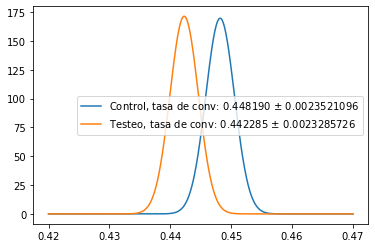

In [71]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [63]:
salto=(CR_test - CR_crl)/CR_crl

salto #%de mejora o empeora la conversion

-0.01317565585974659

In [31]:
salto=(beta_test.mean() - beta_control.mean())/beta_control.mean()

salto

-0.013175098158249857

In [26]:
#!pip install mpmath

from mpmath import betainc   # integral de beta

In [65]:
beta.cdf(0.445,a_T,b_T)   #sitio de corte #el profe lo hizo con otra
prob=beta.cdf(0.445,a_T,b_T) #el area del test del punto de corte

prob=float(prob)


prob #probab de mejorar o empeorar la conversion en el % del salto. Probabilidad de acertar el salto.

0.8781293616836622

In [ ]:
#El test desciende la tasa de conversion en un -0.0132 con un probabilidad del 0.878

In [83]:
# testeo para retention_7
ret2_ctrl_true= len(data[data['retention_7']==True][data['version']=='gate_30'])  #
ret2_ctrl_false= len(data[data['retention_7']==False][data['version']=='gate_30'])
ret2_test_true=len(data[data['retention_7']==True][data['version']=='gate_40'])
ret2_test_true=len(data[data['retention_7']==False][data['version']=='gate_40'])

/var/folders/bg/_zqwsn3n223bm28sndqq_c4h0000gn/T/ipykernel_1225/2753351042.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ret2_ctrl_true= len(data[data['retention_7']==True][data['version']=='gate_30'])  #
/var/folders/bg/_zqwsn3n223bm28sndqq_c4h0000gn/T/ipykernel_1225/2753351042.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ret2_ctrl_false= len(data[data['retention_7']==False][data['version']=='gate_30'])
/var/folders/bg/_zqwsn3n223bm28sndqq_c4h0000gn/T/ipykernel_1225/2753351042.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ret2_test_true=len(data[data['retention_7']==True][data['version']=='gate_40'])
/var/folders/bg/_zqwsn3n223bm28sndqq_c4h0000gn/T/ipykernel_1225/2753351042.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ret2_test_true=len(data[data['retention_7']==False][data['version']=='gate_40'])


In [131]:
# muestreo
imp_ctrl2, conv_ctrl2= version2, ret2_ctrl_true  #total de grupo control/convertidos
imp_test2, conv_test2= version2, ret2_test_true

In [132]:
CR_crl2= conv_ctrl2/imp_ctrl2 #total de grupo control/convertidos
CR_test2= conv_test2/imp_test2

CR_crl2, CR_test2   #conversion rate, tasas cuántos de cada 100 se han convertido

(0.1869023280353492, 0.8179999560333268)

In [133]:
# aprioris 
from scipy.stats import bernoulli, beta

a_C2, b_C2 = conv_ctrl2+1, imp_ctrl2-conv_ctrl2+1  #Para actualizar la beta: a_c los que han convertido y b los no convertidos
a_T2, b_T2 = conv_test2+1, imp_test2-conv_test2+1

beta_control2=beta(a_C2, b_C2)
beta_test2=beta(a_T2, b_T2)
beta_control2.mean(), beta_test2.mean()

(0.18691609329317888, 0.8179859752478512)

In [136]:
x=np.linspace(0.150, 1 , 1000)  #empezar con (0,1,1000) 1000 es los puntos a pintar y 0,1 el umbral de x

def plot(betas, nombres):   #betas y nombres de la leyenda
    
    for bet, nom in zip(betas, nombres):   #en diccionario beta nombre
        
        y=bet.pdf(x)  #pdf es la funcion la linea (cdf es la integral el area)
        y_media=bet.mean() # pa la leyenda
        y_std=bet.std()  # pa la leyenda
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std)) #(x,y, label=leyenda)
        #plt.yticks([]) #si se descomenta quita los valores de la y 
        
    plt.legend()
    plt.show();

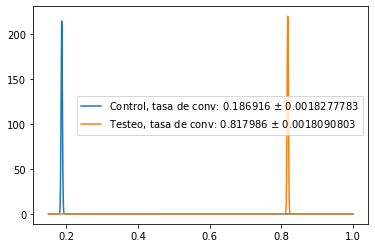

In [137]:
plot([beta_control2, beta_test2], ['Control', 'Testeo'])

In [89]:
salto2=(beta_test2.mean() - beta_control2.mean())/beta_control2.mean()

salto2

-0.013175098158249857

In [90]:
beta.cdf(0.445,a_T,b_T)   #sitio de corte #el profe lo hizo con otra
prob2=beta.cdf(0.445,a_T,b_T) #el area del test del punto de corte

prob2=float(prob)


prob2 #probab de mejorar o empeorar la conversion en el % del salto. Probabilidad de acertar el salto.

0.8781293616836622